# Project: Investigate Movie Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
In this report, we will be applying data analysis process on TMDb movie data. This data set contains information about 10,000+ movies collected from The Movie Database (TMDb), including user ratings and revenue. 
Here are the problem we address:
<ul>
    <li>
        <a href="#q1">Which genres are most popular from year to year?</a>
    </li>
    <li>
        <a href="#q2">What kinds of properties are associated with movies that have high revenues?</a>
    </li>
    <li>
        <a href="#q3">Which movie earn the most over time? Which earn the least?</a>
    </li>
    <li>
        <a href="#q4">How much has the drama movie revenue improved over time?</a>
    </li>
    <li>
        <a href="#q5">What is the proportion of each genre since 1960?</a>
    </li>
</ul>

### Import All Packages We Need

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import decimal

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### Load in the Data

In [120]:
# Load data and print out a few lines.
movie_df = pd.read_csv('tmdb-movies.csv')
movie_df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


### General Properties

#### Dimensions of the Dataset

In [121]:
movie_df.shape

(10866, 21)

#### Data types for each feature

In [122]:
movie_df.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

#### Check Nnumber of Missing Value

In [123]:
movie_df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

#### Check Number of Dulicate Row

In [124]:
movie_df.duplicated().sum()

1

#### Problem With Cast and Genres
Certain columns, like ‘cast’ and ‘genres’, contain multiple values separated by pipe (|) 

In [125]:
movie_df.head(1).cast

0    Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...
Name: cast, dtype: object

In [126]:
movie_df.head(1).genres

0    Action|Adventure|Science Fiction|Thriller
Name: genres, dtype: object

### Data Cleaning

#### Drop Unused Columns

In [127]:
movie_df.drop(['id', 'imdb_id', 'homepage'], axis=1, inplace=True)

In [128]:
# Double-check our columns, ensure we have successfully drop unused columns
movie_df.columns

Index(['popularity', 'budget', 'revenue', 'original_title', 'cast', 'director',
       'tagline', 'keywords', 'overview', 'runtime', 'genres',
       'production_companies', 'release_date', 'vote_count', 'vote_average',
       'release_year', 'budget_adj', 'revenue_adj'],
      dtype='object')

#### Drop Rows with Any Null Aalue

In [129]:
movie_df.dropna(inplace=True) 

# check null values exist or not
movie_df.isnull().sum().any()

False

#### Drop Duplicates

In [130]:
movie_df.drop_duplicates(inplace=True)

# print number of duplicates
movie_df.duplicated().sum()

0

#### Break Multi Values Cell
Since genres contain multi values separated by pipe (|), we need to separate them into multiple rows. Below is the function for separating.

In [131]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def splitListToRows(row, separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)

    df.apply(splitListToRows, axis=1, args = (separator, ))
    new_df = pd.DataFrame(row_accumulator)
    return new_df

In [132]:
movie_df.head(1).genres

0    Action|Adventure|Science Fiction|Thriller
Name: genres, dtype: object

In [133]:
# Use the function we just created break row to rows
movie_df = splitDataFrameList(movie_df, 'genres', '|')

# double check the yield
movie_df.head(4).genres

0             Action
1          Adventure
2    Science Fiction
3           Thriller
Name: genres, dtype: object

<a id='eda'></a>
## Exploratory Data Analysis

We've trimmed and cleaned our data, we're ready to explore further on our dataset. 
<span id="q1"></span>
### Which genres are most popular from year to year?
There are several steps for solving this problem:
<ol>
    <li>Split each year into different group</li>
    <li>Split each genre into subgroup in each group</li>
    <li>Calculate the sum of popularity of each subgroup</li>
    <li>Get the index of the max group</li>
    <li>Retrieve the max data points</li>
</ol>

In [134]:
# group by release_year and genres, sum popularity in each genres
sum_pop = movie_df.groupby(['release_year','genres']).agg({'popularity': 'sum'}).reset_index()

# We then have all the sums for each genres
sum_pop[sum_pop['release_year'] == 1960]

,release_year,genres,popularity
0,1960,Action,4.007634
1,1960,Adventure,3.504904
2,1960,Comedy,3.112182
3,1960,Crime,0.692959
4,1960,Drama,6.643805
5,1960,Family,0.834191
6,1960,Fantasy,0.856495
7,1960,History,1.610094
8,1960,Horror,4.140147
9,1960,Music,0.423531


However, we only need the most popular genre in each year. 

In [135]:
# get the index of the most popular genres
idx = sum_pop.groupby('release_year').popularity.transform(max) == sum_pop['popularity']

# Retrieve the max data points
df = sum_pop[idx]

# we then have the top genre in each year
df.reset_index(inplace=True, drop=True)
df.head()

,release_year,genres,popularity
0,1960,Drama,6.643805
1,1961,Drama,6.915731
2,1962,Drama,7.041713
3,1963,Thriller,7.199292
4,1964,Comedy,7.540430


We already have the data for plotting the diagram. However, I am planning to plot each genre into a different color. Let's check what genres we have:

In [136]:
# check avaliable genres
gen_arr = df.genres.unique()
gen_arr

array(['Drama', 'Thriller', 'Comedy', 'Adventure', 'Action'], dtype=object)

Create x and y for each genre.

In [137]:
drama_x = df.query('genres == "Drama"').release_year
drama_y = df.query('genres == "Drama"').popularity

thriller_x = df.query('genres == "Thriller"').release_year
thriller_y = df.query('genres == "Thriller"').popularity

comedy_x = df.query('genres == "Comedy"').release_year
comedy_y = df.query('genres == "Comedy"').popularity

adventure_x = df.query('genres == "Adventure"').release_year
adventure_y = df.query('genres == "Adventure"').popularity

action_x = df.query('genres == "Action"').release_year
action_y = df.query('genres == "Action"').popularity

plot each x and y.

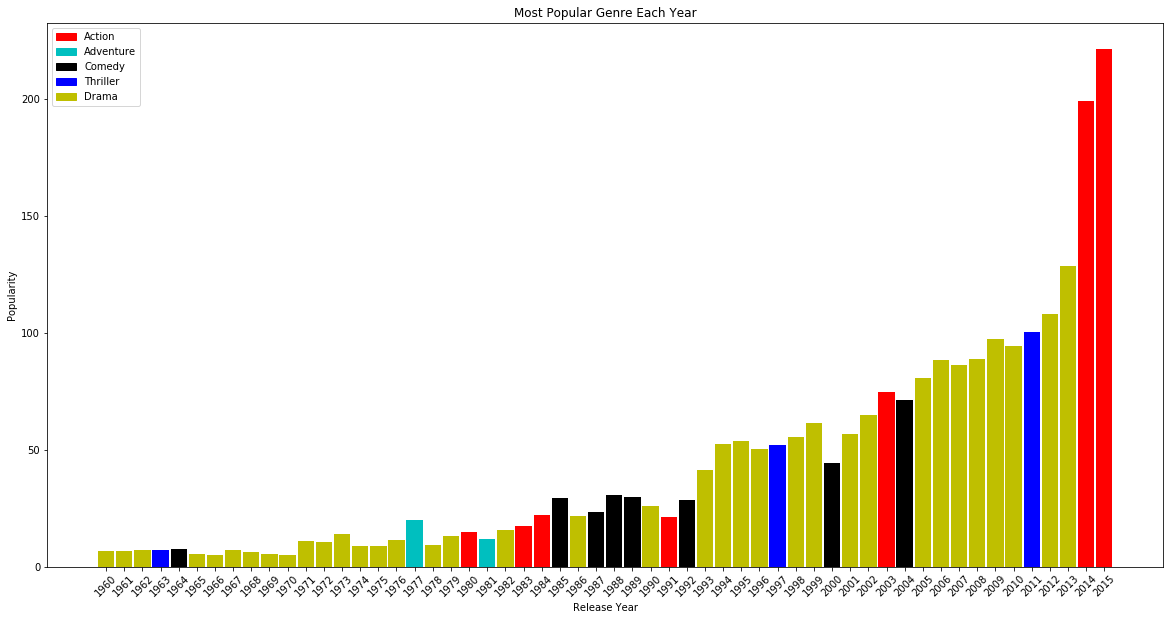

In [138]:
plt.figure(figsize=(20,10))

plt.bar(drama_x, drama_y, width = 0.90, align='center', color='y')
plt.bar(thriller_x, thriller_y, width = 0.90, align='center', color='b')
plt.bar(comedy_x, comedy_y, width = 0.90, align='center', color='k')
plt.bar(adventure_x, adventure_y, width = 0.90, align='center', color='c')
plt.bar(action_x, action_y, width = 0.90, align='center', color='r')

plt.xticks(df.release_year, rotation=45)
plt.xlabel('Release Year')
plt.ylabel('Popularity')
plt.title('Most Popular Genre Each Year')

r_patch = mpatches.Patch(color='red', label='Action')
c_patch = mpatches.Patch(color='c', label='Adventure')
k_patch = mpatches.Patch(color='k', label='Comedy')
b_patch = mpatches.Patch(color='b', label='Thriller')
y_patch = mpatches.Patch(color='y', label='Drama')

plt.legend(handles=[r_patch,c_patch,k_patch,b_patch,y_patch])

plt.show();

As we can see, the trend is gradually climbing upwards while there is a drastic increase in 2014; This tells us the population of moviegoers is increasing. Moreover, Drama occupies the top seat for many years since 1960. However, Action movies tend to be favorable recently.

<a id="q2"></a>
### What kinds of properties are associated with movies that have high revenues?
There are several steps for solving this problem:
<ol>
    <li>Find the mean of revenues</li>
    <li>Retrieve those movies that have revenue greater than mean</li>
</ol>

#### Find the mean of revenues and retrieve data

In [139]:
# Since there is inflation, we use revenue_adj instead of revenue. 
# Calculate the mean for this feature.
revenue_mean = movie_df.revenue_adj.mean()

# retrieve high revenues movies and low revenues movies
high_ren_movie = movie_df.query('revenue_adj >= @revenue_mean')
low_ren_movie = movie_df.query('revenue_adj < @revenue_mean')

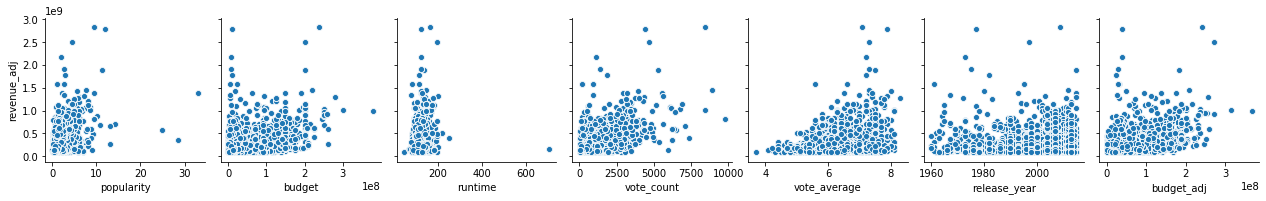

In [140]:
sns.pairplot(high_ren_movie, 
             x_vars=["popularity", "budget", "runtime", "vote_count", "vote_average", "release_year", "budget_adj"],
             y_vars=["revenue_adj"],
             kind="scatter", palette="husl")
plt.show()

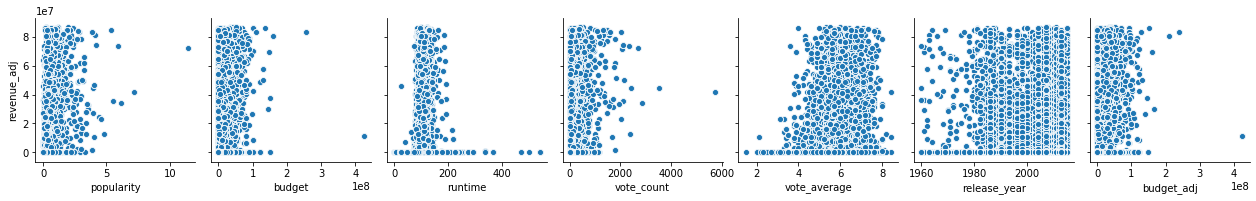

In [141]:
sns.pairplot(low_ren_movie, 
             x_vars=["popularity", "budget", "runtime", "vote_count", "vote_average", "release_year", "budget_adj"],
             y_vars=["revenue_adj"],
             kind="scatter", palette="husl")
plt.show()

As we can see on the graphs on high revenue movies, revenue_adj has a positive correlation with most of the features except runtime. At the same time, the relationship in low revenue movie is not too noticeable. Let's take a further look.

#### Find Average and Subtract
Find the average of each feature in both low and high revenue data frames:

In [144]:
# find the properties average of high revenue movie
high = high_ren_movie.mean(axis = 0)
low = low_ren_movie.mean(axis = 0)

In [145]:
# find the properties average of high revenue movie
inc = high - low

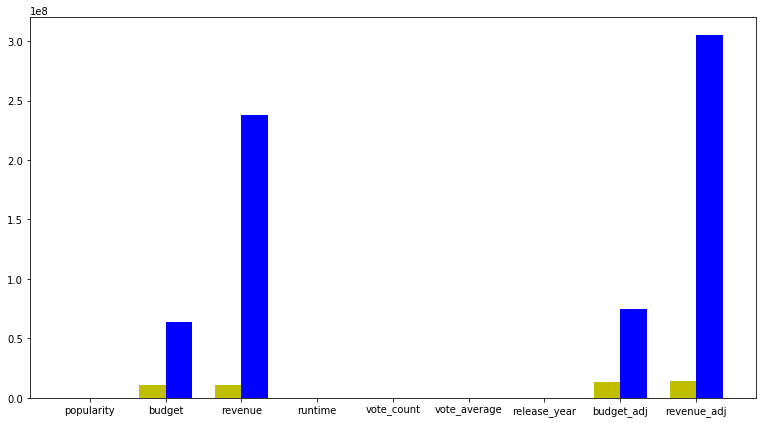

popularity      1.365998e+00
budget          5.261024e+07
revenue         2.270119e+08
runtime         1.278599e+01
vote_count      8.941145e+02
vote_average    4.785441e-01
release_year    6.586035e-01
budget_adj      6.086291e+07
revenue_adj     2.907299e+08
dtype: float64

In [146]:
ind = np.arange(9) 

width = 0.35
plt.figure(figsize=(13, 7))
plt.bar(ind, low, width, color='y', label = "low")
plt.bar(ind + 0.35, high, width, color='b', label = "high")
plt.xticks(ind + width / 2, (low.index))

plt.show()
inc

According to the above data, high revenue movies usually associate with a high budget, high vote_count, and high vote_average. Popularity, runtime, and release_year, on the other hand, have less association. <br/><br/>
We just made our observation on numeric features. Let's take a look at the text features of the dataset. (cast, director, tagline, keywords, overview, production_companies)

#### Keywords:

In [147]:
avg_word_high = high_ren_movie.keywords.apply(lambda x: len(x.split("|"))).mean()
avg_word_high

4.668272388876725

In [148]:
avg_word_low = low_ren_movie.keywords.apply(lambda x: len(x.split("|"))).mean()
avg_word_low

4.085902118334551

#### Overview:

In [149]:
avg_over_high = high_ren_movie.overview.apply(lambda x: len(x.split("|"))).mean()
avg_over_high

1.0

In [150]:
avg_over_low = low_ren_movie.overview.apply(lambda x: len(x.split("|"))).mean()
avg_over_low

1.0001460920379839

#### Tagline:

In [151]:
avg_tag_high = high_ren_movie.tagline.apply(lambda x: len(x.split("|"))).mean()
avg_tag_high

1.0

In [152]:
avg_tag_low = low_ren_movie.tagline.apply(lambda x: len(x.split("|"))).mean()
avg_tag_low

1.0

#### Production_companies:

In [153]:
avg_production_high = high_ren_movie.production_companies.apply(lambda x: len(x.split("|"))).mean()
avg_production_high

2.8745347054959494

In [76]:
avg_production_low = low_ren_movie.production_companies.apply(lambda x: len(x.split("|"))).mean()
avg_production_low

2.375018261504748

In conclusion, high revenue movies usually associate with:
<ol>
    <li>a high budget</li>
    <li>high vote_count</li>
    <li>high vote_average</li>
    <li>Slightly more keywords</li>
    <li>Slightly more production companies</li>
<ol/>

<span id="q3"></span>
### Which movie earned the most since 1960? Which makes the least?
Since inflation is a concern, we use revenue_adj instead of revenue. Profit = revenue - budget.

In [87]:
movie_df['profit'] = movie_df['revenue_adj'] - movie_df['budget_adj']

most_earn = movie_df[movie_df['profit'] == movie_df['profit'].max()].original_title.unique()

least_earn = movie_df[movie_df['profit'] == movie_df['profit'].min()].original_title.unique()

print(most_earn[0], "earn the most.")
print(least_earn[0], "earn the least.")

Star Wars earn the most.
The Warrior's Way earn the least.


<a id="q4"></a>
### How much has the drama movie revenue improved over time?
<ol>
    <li>Find all action movies.</li>
    <li>Group those action movies by year.</li>
    <li>Calculate mean revenue in each group.</li>
</ol>

In [113]:
# find all action movie
drama_df = movie_df.query('genres == "Drama"')

# Group action movie by year, and calculate mean revenue for each group.
drama_ren = drama_df.groupby('release_year').agg({'revenue_adj': 'mean'}).reset_index()

drama_ren.head()

,release_year,revenue_adj
0,1960,9.068750e+07
1,1961,5.085438e+07
2,1962,5.935515e+07
3,1963,5.179930e+07
4,1964,3.530610e+07


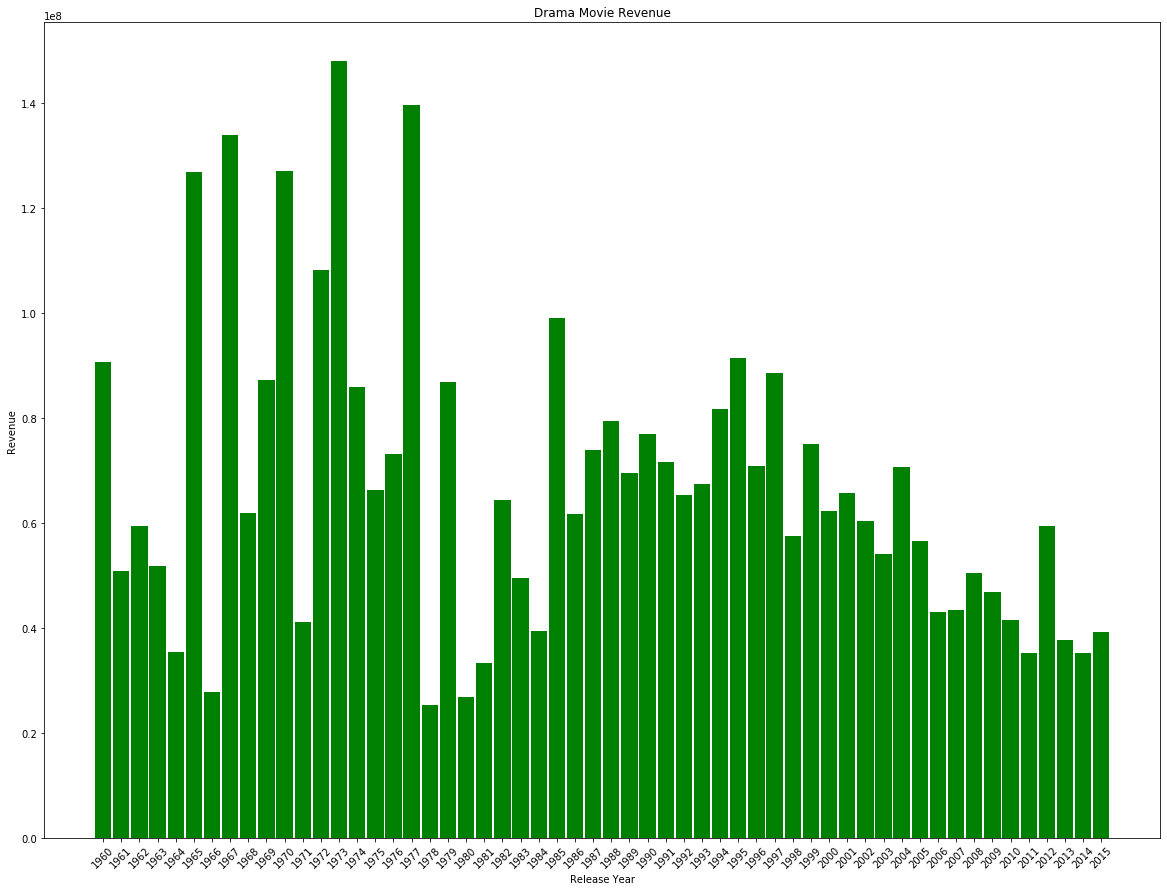

In [117]:
plt.figure(figsize=(20, 15))

plt.bar(drama_ren.release_year, drama_ren.revenue_adj, width = 0.90, align='center', color='g')
plt.xticks(drama_ren.release_year, rotation=45)

plt.xlabel('Release Year')
plt.ylabel('Revenue')
plt.title("Drama Movie Revenue")

plt.show();

The revenue of the drama movie fluctuates heavily between 1960 and 1985. After 1985, the trend is gradually going downwards.

<span id="q5"></span>
### What is the proportion of each genre since 1960?

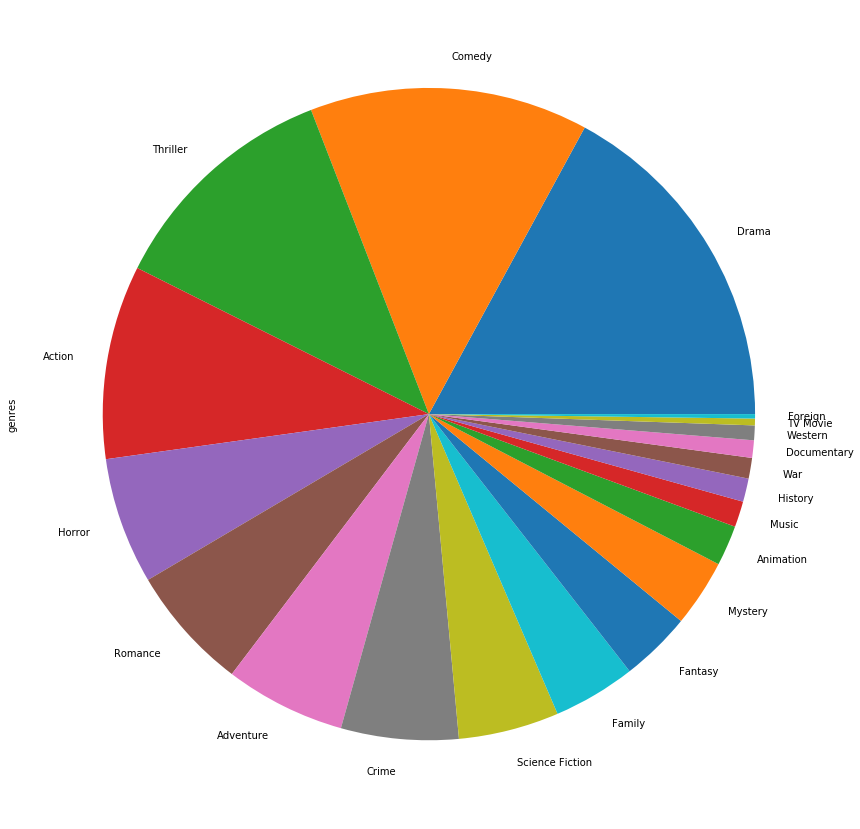

In [96]:
movie_df.genres.value_counts().plot(kind="pie", figsize=(15, 15));

As we can see on the above pie chart, the four main genres from highest to lowest are Drama, Comedy, Thriller and Action.

<a id='conclusions'></a>
## Conclusions

<ul>
    <li>
        <a href="#q1">Which genres are most popular from year to year?</a> <br/>
        The trend of popularity is gradually climbing upwards while there is a drastic increase in 2014; This tells us the population of moviegoers is increasing. Moreover, Drama occupies the top seat for many years since 1960. However, Action movies tend to be favorable recently.
    </li>
    <li>
        <a href="#q2">What kinds of properties are associated with movies that have high revenues?</a>
        <div>High revenue movies usually associate with:</div>
        <ol>
            <li>a high budget</li>
            <li>high vote_count</li>
            <li>high vote_average</li>
            <li>Slightly more keywords</li>
            <li>Slightly more production companies</li>
        </ol>
    </li>
    <li>
        <a href="#q3">Which movie earn the most over time? Which earn the least?</a> 
        <div>
            Star Wars earn the most. <br>
            The Warrior's Way earn the least.
        </div>
    </li>
    <li>
        <a href="#q4">How much has the drama movie revenue improved over time?</a>
        <div>
            The revenue of the drama movie fluctuates heavily between 1960 and 1985. After 1985, the trend is gradually going downwards.
        </div>
    </li>
    <li>
        <a href="#q5">What is the proportion of each genre since 1960?</a>
        <div>
            As we can see from the above pie chart, the four main genres from highest to lowest are Drama, Comedy, Thriller, and Action.
        </div>
    </li>
</ul>